Esse é um notebook com uma análise inicial dos modelos mais usados na competição de NLP, o código e as explicações desse código são retiradas de códigos disponibilizados por competidores humildes. A partir daqui teremos uma noção inicial do que fazer na competição, os modelos que são estado da arte nesse tipo de avaliação, ao fim dele saberemos o que deve ser estudado e aprofundado, além disso poderemos ter noção para onde partir, o que podemos melhorar.

Fontes:

https://www.kaggle.com/code/yongsukprasertsuk/0-812-5-fold-deberta-lgbm?scriptVersionId=172806983#%E2%96%B6%EF%B8%8F-Ensemble-%E2%97%80%EF%B8%8F

https://www.kaggle.com/code/xianhellg/more-feature-engineering-feature-selection-0-817#Data-Loading

https://www.kaggle.com/code/zulqarnainalipk/lgbm-deberta-explained/notebook


https://www.kaggle.com/code/hideyukizushi/aes2-deberta-lgbm-countvectorizer-lb-819 (0.819)

In [ ]:
#Principais coisas a estudar: LGBM, Deberta e ensamble learning

#Visualização inicial dos dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
df_teste = pd.read_csv('/content/drive/MyDrive/CompNLP/test.csv')
df_teste

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


In [ ]:
df_teste['predicted_score'] = 0

In [ ]:
df_teste #Só há realmente 3 testes

,essay_id,full_text,predicted_score
0,000d118,Many people have car where they live. The thin...,0
1,000fe60,I am a scientist at NASA that is discussing th...,0
2,001ab80,People always wish they had the same technolog...,0


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CompNLP/sample_submission.csv') #Como o nome diz esse é só um exemplo de submissão

In [ ]:
df

,essay_id,score
0,000d118,3
1,000fe60,3
2,001ab80,4


In [ ]:
df_treino = pd.read_csv('/content/drive/MyDrive/CompNLP/train.csv')
df_treino

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3
...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2
17303,ffddf1f,Technology has changed a lot of ways that we l...,4
17304,fff016d,If you don't like sitting around all day than ...,2
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1


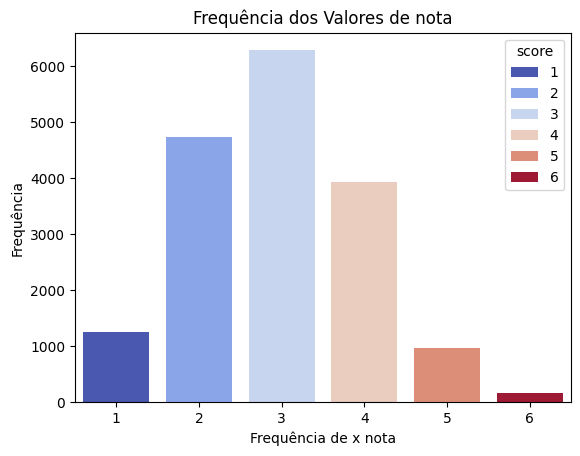

In [ ]:
frequency = df_treino['score'].value_counts().reset_index()
frequency.columns = ['score', 'Frequency']
sns.barplot(data=frequency, x='score', y='Frequency', hue='score', palette='coolwarm')
plt.xlabel('Frequência de x nota')
plt.ylabel('Frequência')
plt.title('Frequência dos Valores de nota')
plt.show()

In [ ]:
df_treino['full_text'][5]

"If I were to choose between keeping the electoral college or abolishing it, I would chose for abolishing it. The electoral college has a system that can be considered confusing to most americans. This system indirectly transfers citizen's votes to congress. This allows for loopholes and sabaotage to be commited during the process of electing a president.\n\nI propose abolishing the electoral college and replacing it with a simpler system that appeals to all united states citizens instead of just certain citizens. Based on phrases in the passage, there is evidence that the electoral college system is corrupt. An example would be:\n\nBack in 1960. segregationalists in the Louisiana legislature nearly succeeded in relpacing the Democratic electors with new electors who would oppose John F. Kennedy. (So that a popular vote for Kennedy would not have actually gone to Kennedy.)\n\n-source 2, second paragraph.\n\nThis is stating that in 1960 people who opposed Kennedy nearly became his elect

In [ ]:
df_treino['full_text'][2]

'People always wish they had the same technology that they have seen in movies, or the best new piece of technology that is all over social media. However, nobody seems to think of the risks that these kinds of new technologies may have. Cars have been around for many decades, and now manufacturers are starting to get on the bandwagon and come up with the new and improved technology that they hope will appeal to everyone. As of right now, it seems as though the negative characteristics of these cars consume the positive idea that these manufacturers have tried to convey.\n\nCurrently, this new technology in cars has a very long way to go before being completely "driverless". Drivers still need to be on alert when they are driving, as well as control the car near any accidents or complicated traffic situations. This seems to totally defeat the purpose of the "driverless" car. Eventually the technology may improve, but nobody can be certain that the driverless car will eventually become 

Não há muito o que analisar no dataset, só há uma feature além do texto, que é sua nota. Não muito o que retirar da leitura bruta do texto. Logo caberá a nós a partir de informações do texto extrairmos informações importantes e úteis para a avaliação dos textos.

#Feature Extration + análise delas

Pensar e analisar outras features que podemos criar a partir dos textos

##Contador de parágrafos:

In [ ]:
df_treino['paragraph'] = df_treino['full_text'].str.split('\n\n') #Vou fazer uma coluna com a divisão em parágrafos

In [ ]:
df_treino

,essay_id,full_text,score,paragraph
0,000d118,Many people have car where they live. The thin...,3,[Many people have car where they live. The thi...
1,000fe60,I am a scientist at NASA that is discussing th...,3,[I am a scientist at NASA that is discussing t...
2,001ab80,People always wish they had the same technolog...,4,[People always wish they had the same technolo...
3,001bdc0,"We all heard about Venus, the planet without a...",4,"[We all heard about Venus, the planet without ..."
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,"[Dear, State Senator, This is a letter to argu..."
...,...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,"[the story "" The Challenge of Exploing Venus ""..."
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,[Technology has changed a lot of ways that we ...
17304,fff016d,If you don't like sitting around all day than ...,2,[If you don't like sitting around all day than...
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,"[In ""The Challenge of Exporing Venus,"" the aut..."


In [ ]:
df_treino['paragraph'][2]

['People always wish they had the same technology that they have seen in movies, or the best new piece of technology that is all over social media. However, nobody seems to think of the risks that these kinds of new technologies may have. Cars have been around for many decades, and now manufacturers are starting to get on the bandwagon and come up with the new and improved technology that they hope will appeal to everyone. As of right now, it seems as though the negative characteristics of these cars consume the positive idea that these manufacturers have tried to convey.',
 'Currently, this new technology in cars has a very long way to go before being completely "driverless". Drivers still need to be on alert when they are driving, as well as control the car near any accidents or complicated traffic situations. This seems to totally defeat the purpose of the "driverless" car. Eventually the technology may improve, but nobody can be certain that the driverless car will eventually becom

In [ ]:
df_treino.explode('paragraph') #Essa função fará uma nova linha para cada parágrafo do texto (ver se uso isso ou n)

,essay_id,full_text,score,paragraph
0,000d118,Many people have car where they live. The thin...,3,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...,3,I am a scientist at NASA that is discussing th...
1,000fe60,I am a scientist at NASA that is discussing th...,3,"First off, how could it be a martions drawing...."
1,000fe60,I am a scientist at NASA that is discussing th...,3,"Next, why it is a landform. There are many lan..."
1,000fe60,I am a scientist at NASA that is discussing th...,3,"Finaly, why you should listen to me. You shoul..."
...,...,...,...,...
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,"In ""The Challenge of Exporing Venus,"" the auth..."
17306,fffed3e,Venus is worthy place to study but dangerous. ...,2,Venus is worthy place to study but dangerous. ...
17306,fffed3e,Venus is worthy place to study but dangerous. ...,2,of the Planet.
17306,fffed3e,Venus is worthy place to study but dangerous. ...,2,Just like when they sent a robot to the planet...


In [ ]:
df_treino['n_paragraph'] = 0

In [ ]:
len(df_treino['paragraph'][2])

4

In [ ]:
df_treino['n_paragraph'] = df_treino['paragraph'].str.len()

In [ ]:
df_treino

,essay_id,full_text,score,paragraph,n_paragraph
0,000d118,Many people have car where they live. The thin...,3,[Many people have car where they live. The thi...,1
1,000fe60,I am a scientist at NASA that is discussing th...,3,[I am a scientist at NASA that is discussing t...,5
2,001ab80,People always wish they had the same technolog...,4,[People always wish they had the same technolo...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4,"[We all heard about Venus, the planet without ...",5
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,"[Dear, State Senator, This is a letter to argu...",6
...,...,...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,"[the story "" The Challenge of Exploing Venus ""...",3
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,[Technology has changed a lot of ways that we ...,6
17304,fff016d,If you don't like sitting around all day than ...,2,[If you don't like sitting around all day than...,3
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,"[In ""The Challenge of Exporing Venus,"" the aut...",1


In [ ]:
df_treino['full_text'][0]

'Many people have car where they live. The thing they don\'t know is that when you use a car alot of thing can happen\xa0like you can get in accidet or\xa0the smoke that the car has is bad to breath\xa0on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban\'s families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden\xa0on the outskirts of freiburd that near the French and Swiss borders. You probaly won\'t see a car in Vauban\'s streets because they are completely "car free" but\xa0If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states an

Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely "car free" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called "smart planning". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that "All of our development since World war 2 has been centered on the cars,and that will have to change" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called "car reduced"communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this.    

In [ ]:
#Realmente há textos com 1 único parágrafo

In [ ]:
df_treino['n_paragraph'].describe()

count    17307.000000
mean         4.965274
std          3.311622
min          1.000000
25%          3.000000
50%          5.000000
75%          5.000000
max         66.000000
Name: n_paragraph, dtype: float64

In [ ]:
#Analisar esses com muitos parágrafos

##Contador de palavras

## Contador de erros ortográficos

##Aplicar bertopic:

In [ ]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 56.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 23.3 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (7

In [ ]:
from bertopic import BERTopic

In [ ]:
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords = set(stopwords.words('english'))
stopwords=list(stopwords)
vectorizer_model  = CountVectorizer(stop_words=stopwords)

In [ ]:
#Vou deixar aqui todas as bibliotecas e funções necessárias a serem importadas para deixar o resumo completo:
from bertopic.representation import MaximalMarginalRelevance
from transformers import pipeline
from bertopic.representation import TextGeneration
from bertopic.representation import KeyBERTInspired
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

In [ ]:
#Setando os parâmetros do HDBSCAN e do UMAP, além de retirar as stopwords da representação, o mesmo que fiz durante todo o estudo
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True, random_state=50)
vectorizer_model  = CountVectorizer(stop_words=stopwords)

In [ ]:
#Inicialização a representação multípla, algo que vejo como muito útil
prompt = "I have a topic described by the following keywords: [KEYWORDS]. Based on the previous keywords, what is this topic about?"
generator = pipeline('text2text-generation', model='google/flan-t5-base')
main_representation = KeyBERTInspired()
aspect_model1 = TextGeneration(generator)
aspect_model2 = MaximalMarginalRelevance(diversity=0.8)
representation_model = {
   "Main": main_representation,
   "Aspect1":  aspect_model1,
   "Aspect2":  aspect_model2 }

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
topic_model10 = BERTopic(umap_model=umap_model, embedding_model = 'all-mpnet-base-v2',
                         vectorizer_model = vectorizer_model, calculate_probabilities=True,
                         min_topic_size=20, representation_model=representation_model)

In [ ]:
topicos10, probs10 = topic_model10.fit_transform(df_treino['full_text'])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
topic_model10.get_topic_info()

,Topic,Count,Name,Representation,Aspect1,Aspect2,Representative_Docs
0,0,3498,0_driverless_driveless_driver_driving,"[driverless, driveless, driver, driving, drive...","[driverless cars, , , , , , , , , ]","[driverless, driveless, driver, driving, drive...",[Driverless cars are a dangerous thing that th...
1,1,3043,1_emotion_emotions_emotional_faces,"[emotion, emotions, emotional, faces, face, sm...","[facial expressions in a classroom, , , , , , ...","[emotion, emotions, emotional, faces, face, sm...",[A new technology called the Facial Action Cod...
2,2,3018,2_venus_planets_planet_explore,"[venus, planets, planet, explore, exploring, a...","[venus, , , , , , , , , ]","[venus, planets, planet, explore, exploring, a...",[Studying Venus is a worthy pursuit despite th...
3,3,2093,3_face_mars_martian_mesa,"[face, mars, martian, mesa, landform, aliens, ...","[aliens face the mesa of mars, , , , , , , , , ]","[face, mars, martian, mesa, landform, aliens, ...","[Many people believe this very famous ""Face on..."
4,4,2046,4_electors_electoral_elector_elect,"[electors, electoral, elector, elect, voters, ...","[election of electors, , , , , , , , , ]","[electors, electoral, elector, elect, voters, ...","[Dear state senator,\n\nThere should be a chan..."
5,5,1961,5_driving_vehicles_car_cars,"[driving, vehicles, car, cars, pollution, emis...","[diesel emissions, , , , , , , , , ]","[driving, vehicles, car, cars, pollution, emis...",[The effect of cars in our world today has gro...
6,6,1648,6_seagoing_cowboy_adventure_ship,"[seagoing, cowboy, adventure, ship, cowboys, t...","[cowboys on a boat travel the sea, , , , , , ,...","[seagoing, cowboy, adventure, ship, cowboys, t...",[My name is Luke Bomberger and I made nine tri...


In [ ]:
topic_model10.visualize_topics()

In [ ]:
topic_model10.visualize_heatmap()

Olhando um pouco mais para os termos da representação e sua influência nela:

In [ ]:
topic_model10.visualize_barchart(n_words = 10)

In [ ]:
topic_model10.visualize_term_rank()

Mostrando uma das mais importantes funções do HDBSCAN, vou hierarquizar os tópicos para ser possíveis visualizar os estágios mais acima dos clusters

In [ ]:
hierarchical_topics = topic_model10.hierarchical_topics(df_treino['full_text'])

100%|██████████| 6/6 [00:02<00:00,  2.94it/s]


In [ ]:
topic_model10.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

Agora uma forma mais detalhada para conseguirmos olhar os documentos mais especificamente em cada tópico

In [ ]:
topic_distr, topic_token_distr = topic_model10.approximate_distribution(df_treino['full_text'], calculate_tokens=True)
topic_model10.visualize_approximate_distribution(df_treino['full_text'][965], topic_token_distr[965])

,Humans,are,slowly,destroying,earth,and,scientists,have,not,found,successful,plan,for,us,to,follow,Further,exploration,into,Venus,could,lead,to,safe,place,for,humans,and,proof,that,there,has,been,other,lifeforms,Venus,could,quite,possibly,be,safe,for,humans,If,humans,use,hovercraft,to,float,above,the,surface,temperatures,would,be,about,170,degrees,Fahrenheit,It,would,be,hot,but,it,would,be,survivable,There,are,also,signs,showing,that,there,was,oncewater,we,could,do,water,restoration,project,to,have,waterthere,again,We,have,been,searching,for,signs,of,lifeforms,for,the,longest,time,Venus,shows,signs,of,what,we,have,been,searching,for,The,planet,has,signs,of,previous,oceans,and,has,analagous,features,to,Earth,It,has,rocky,sediment,and,mountains,This,could,mean,there,was,once,lifeforms,on,Venus,In,conclusiom,further,exploration,of,Venus,could,answer,some,of,our,questions,These,questions,having,to,do,with,the,plan,for,when,Earth,finally,gives,up,and,the,conspiracies,of,if,there,are,other,lifeforms
0_driverless_driveless_driver_driving,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.106,0.106,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.196,0.196,0.196,0.196,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1_emotion_emotions_emotional_faces,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.137,0.137,0.137,0.137,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2_venus_planets_planet_explore,0.000,0.000,0.000,0.114,0.312,0.312,0.312,0.198,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.250,0.513,0.798,1.084,0.834,0.571,0.286,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.171,0.359,0.516,0.710,0.538,0.350,0.194,0.000,0.000,0.102,0.102,0.102,0.102,0.000,0.000,0.000,0.000,0.107,0.241,0.375,0.375,0.268,0.134,0.000,0.000,0.104,0.104,0.104,0.104,0.000,0.000,0.106,0.106,0.106,0.106,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.155,0.305,0.487,0.671,0.516,0.366,0.184,0.000,0.000,0.000,0.000,0.102,0.374,0.495,0.615,0.513,0.240,0.120,0.000,0.000,0.000,0.000,0.000,0.176,0.423,0.565,0.565,0.389,0.142,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.171,0.342,0.458,0.574,0

In [ ]:
topic_model10.visualize_distribution(topic_distr[965])

Agora essa visualização hierarquizada, podendo subir os níveis hierarquicos e ver como se comparta a distribuição dos documentos nos tópicos

In [ ]:
topic_model10.visualize_hierarchical_documents(df_treino['full_text'], hierarchical_topics, reduced_embeddings=reduced_embeddings)

IndexError: index -1 is out of bounds for axis 0 with size 0